In [12]:
import joblib

X_train = joblib.load("../data/X_train.pkl")
X_test = joblib.load("../data/X_test.pkl")
y_train = joblib.load("../data/y_train.pkl")
y_test = joblib.load("../data/y_test.pkl")


## Train baseline Logistic Regression
- max_iter=1000 → Logistic Regression uses an iterative optimizer (gradient descent variant). If it does not converge within the default iterations (100), it throws a warning.
> means: “Allow the solver up to 1000 gradient steps to find optimal weights.”

- class_weight="balanced" -> It automatically increases the penalty for misclassifying the minority class.
If you train normally, the model will learn:
> “Always predict 0 → 99.83% accuracy.”
Which is useless.




In [13]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000, class_weight="balanced")
log_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

## Evaluate Logistic Regression
### classification_report
- Precision: predicted frauds, how many were actually fraud.        High Precision → You falsely accuse few normal transactions
- Recall: actual frauds, how many you caught.         High Recall → You catch most frauds
- F1-score: Balance between precision and recall
- Support: Number of samples in each class

In [14]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print(f"Roc-Auc score: {roc_auc_score(y_test, y_prob)}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Roc-Auc score: 0.9720834996210077


## Train Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## Evaluate Random Forest

In [16]:
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, rf_pred))
print(f"Roc-Auc score: {roc_auc_score(y_test, rf_prob)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.82      0.81        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Roc-Auc score: 0.9804269836803601


### Fraud class (1):
* Precision = 0.81 → 81% of fraud alerts are correct
* Recall = 0.82 → catches 82% of all frauds

## Why accuracy is meaningless here
Current dataset is: 56,864 normal & 98 fraud

If you predict "not fraud" always:
> Accuracy = 56,864 / 56,962 = 99.8%

So accuracy near 1.0 tells you nothing.

Ignore accuracy completely for imbalanced problems.





## The real reason RF is better is:

|Metric| |Logistic| |RF|


Fraud Precision	0.06	0.81


Fraud Recall	0.92	0.82


False Alerts	Very-high	Low


Fraud Catch	Very-high	High


Operational Cost	Huge	Manageable

## Plot Precision-Recall vs Threshold

We convert probability → class using a threshold:
>  if probability ≥ threshold → fraud

> else → normal


Our current threshold is set as Default value = 0.5, which is arbitrary and rarely optimal

So we need to find the best threshold as per conditions:
> Case1: Missing fraud is very expensive : You might choose ~0.30. where recall ≥ 0.9

> Case2: False alerts are very expensive : You might choose ~0.70. where precision > 0.8

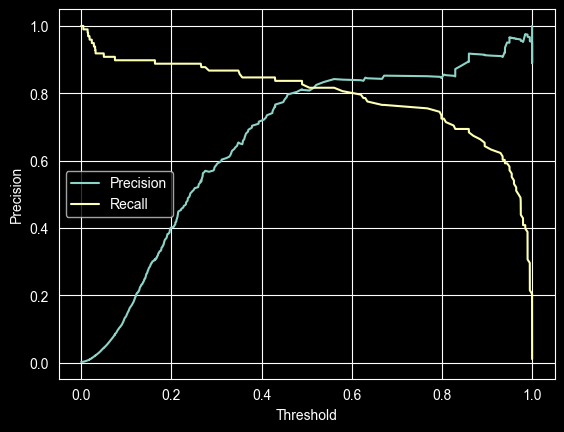

In [22]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, rf_prob)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.legend()
plt.show()

### What does changing threshold do?
Lower threshold (0.2) --> Catch more frauds, more false alarms

Higher threshold (0.8) *shown in graph --> Fewer false alarms, more frauds missed

0.5605939488378827


### Calculate & Apply Best Threshold, Then evaluate


In [123]:
f1 = 2 * (precision * recall) / (precision + recall)
best_index = f1.argmax()
chosen_threshold = thresholds[best_index]
chosen_threshold = 0.48
print(chosen_threshold)

rf_custom_pred = (rf_prob >= chosen_threshold).astype(int)


print(classification_report(y_test, rf_custom_pred))

0.48
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



## Business cost function
Test multiple thresholds and minimize cost.

In [124]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, rf_custom_pred).ravel()
cost = fn * 100 + fp * 1
print("Business cost:", cost)


Business cost: 1619


### SHAP Explainability
This shows:

which features drive fraud detection

model transparency

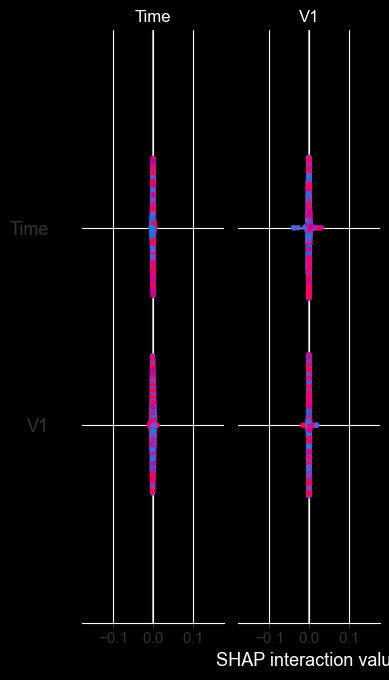

In [125]:
import pandas as pd
import shap

df = pd.read_csv("../data/creditcard.csv")
feature_names = df.drop("Class", axis=1).columns

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.Explainer(rf_model, X_test_df)
shap_values = explainer(X_test_df[:1000])

shap.summary_plot(shap_values.values, X_test_df[:1000], feature_names=feature_names)


# Save final model

In [126]:
import joblib

joblib.dump(rf_model, "../models/fraud_model.pkl")
joblib.dump(chosen_threshold, "../models/threshold.pkl")


['../models/threshold.pkl']